How B92 implementation differs from BB84 implementation

1. **Encoding the key bits**

In BB84, Alice encodes the key bits using four states: `|0>`, `|1>`, `|+>`, and `|->`. This is done using a combination of `X` and `H` gates.

In B92, Alice encodes the key bits using only two states: `|0>` for bit 0 and `|+>` for bit 1. This is done using the `initialize` method.

2. **Bob's measurement basis**

In BB84, Bob randomly chooses between two bases (`'X'` or `'Z'`) for each qubit.

In B92, Bob randomly chooses between two non-orthogonal bases: {`|0>`, `|1>`} and {`|+>`, `|->`}.

3. **Basis reconciliation**

In BB84, Alice and Bob compare their choice of bases (`'X'` or `'Z'`) and keep only the bits where they used the same basis.

In B92, Alice and Bob compare their choice of bases (`'Z'` for {`|0>`, `|1>`} and `'X'` for {`|+>`, `|->`}) and keep only the bits where they used the same basis.


In summary, the main differences lie in the encoding of key bits using different quantum states, the measurement bases used by Bob, and the basis reconciliation step where Alice and Bob compare their choice of bases. The overall structure and the remaining steps, such as sifted key extraction and eavesdropper simulation, are similar in both implementations.

In [131]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer
from qiskit.visualization import plot_histogram

In [132]:
n = 16
qr = QuantumRegister(n, name = 'qr')
cr = ClassicalRegister(n, name = 'cr')

In [133]:
alice = QuantumCircuit(qr, cr, name = 'Alice')
#Generate a random sequence (bit) as the secret key
alice_key = np.random.randint(0, high = 2, size = n)


In [134]:
for index, bit in enumerate(alice_key):
    if bit == 0:
        alice.initialize([1, 0], qr[index])  #State |0>
    else:
        alice.initialize([1/np.sqrt(2), 1/np.sqrt(2)], qr[index])

In [135]:
bob = QuantumCircuit(qr, cr, name = 'Bob')
bob_bases = np.random.randint(0, high=2, size = n)

for index, basis in enumerate(bob_bases):
    if basis == 0:
        bob.initialize([1, 0], qr[index])
    else: 
        bob.initialize([1/np.sqrt(2), 1/np.sqrt(2)], qr[index])
    
    bob.measure(qr[index], cr[index])

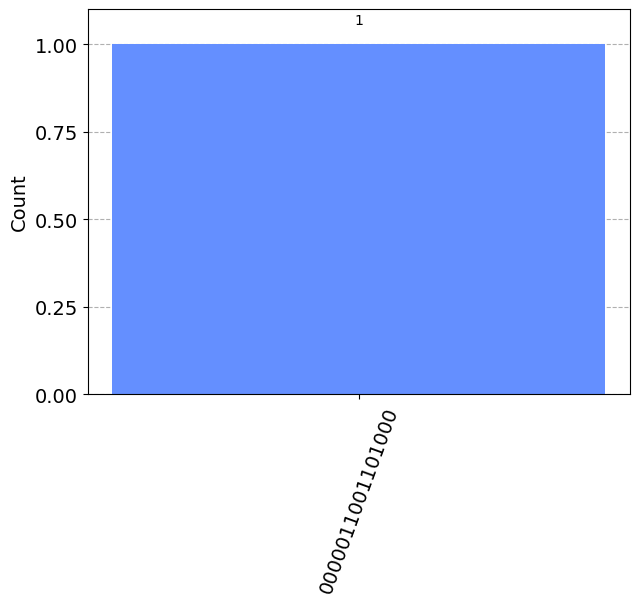

In [136]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))

In [137]:
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

In [138]:
#Basic reconciliation process

keep = []
discard = []
for qubit, basis in enumerate(bob_bases):
    if basis == 0:
        bob_basis = 'Z'
    else:
        bob_basis = 'X'
    

    if alice_key[qubit] == 0:
        alice_basis = 'Z'
    else:
        alice_basis = 'X'

    if alice_basis == bob_basis:
        print(f"Same choice for qubit: {qubit}, basis: {alice_basis}")
        keep.append(qubit)
    else:
        print(f"Different choice for qubit: {qubit}, Alice has {alice_basis}, Bob has {bob_basis}")
        discard.append(qubit)

Same choice for qubit: 0, basis: X
Same choice for qubit: 1, basis: Z
Different choice for qubit: 2, Alice has X, Bob has Z
Same choice for qubit: 3, basis: X
Different choice for qubit: 4, Alice has Z, Bob has X
Same choice for qubit: 5, basis: X
Different choice for qubit: 6, Alice has Z, Bob has X
Different choice for qubit: 7, Alice has X, Bob has Z
Different choice for qubit: 8, Alice has X, Bob has Z
Same choice for qubit: 9, basis: X
Different choice for qubit: 10, Alice has Z, Bob has X
Same choice for qubit: 11, basis: X
Same choice for qubit: 12, basis: Z
Different choice for qubit: 13, Alice has X, Bob has Z
Same choice for qubit: 14, basis: Z
Same choice for qubit: 15, basis: Z


In [139]:
#Calculate % of qubits to be discarded and Measurement convergence
acc = sum(alice_key[qubit] == int(bob_key[qubit]) for qubit in keep)
print('Percentage of qubits to be discarded according to basic reconciliation: ', (n - len(keep)) / n)
print('Measurement convergence by additional chance: ', acc / n)

Percentage of qubits to be discarded according to basic reconciliation:  0.4375
Measurement convergence by additional chance:  0.4375


In [140]:
#Extract the sifted keys after BR
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [int(bob_key[qubit]) for qubit in keep]


In [141]:
acc = sum(new_alice_key[i] == new_bob_key[i] for i in range(len(new_alice_key)))
print('Percentage of similarity between the sifted keys:', acc / len(new_alice_key))

if acc == len(new_alice_key):
    print("Key exchange has been successful")
    print("New Alice's key:", new_alice_key)
    print("New Bob's key:", new_bob_key)
else:
    print("Key exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid:", new_alice_key)
    print("New Bob's key is invalid:", new_bob_key)

Percentage of similarity between the sifted keys: 0.7777777777777778
Key exchange has been tampered! Check for eavesdropper or try again
New Alice's key is invalid: [1, 0, 1, 1, 1, 1, 0, 0, 0]
New Bob's key is invalid: [0, 0, 1, 1, 1, 0, 0, 0, 0]


In [142]:
eve = QuantumCircuit(qr, cr, name='Eve')

In [143]:
eve_bases = np.random.randint(0, high=2, size=n)

for index, basis in enumerate(eve_bases):
    if basis == 0:
        eve.initialize([1, 0], qr[index])  # Measure in {|0>, |1>} basis
    else:
        eve.initialize([1/np.sqrt(2), 1/np.sqrt(2)], qr[index])  # Measure in {|+>, |->} basis

    eve.measure(qr[index], cr[index])

result = execute(eve, backend=backend, shots=1).result()
eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]

In [144]:
for qubit, basis in enumerate(eve_bases):
    if basis == 0:
        eve_basis = 'Z'
    else:
        eve_basis = 'X'
    
    if alice_key[qubit] == 0:
        alice_basis = 'Z'
    else:
        alice_basis = 'X'

    if alice_basis != eve_basis:
        print(f"Different choice for qubit: {qubit}, Alice has {alice_basis}, Eve has {eve_basis}")
        if eve_key[qubit] == alice_key[qubit]:
            eve.h(qr[qubit])
        else:
            if alice_basis == 'X' and eve_basis == 'Z':
                eve.h(qr[qubit])
                eve.x(qr[qubit])
            else: 
                eve.x(qr[qubit])
                eve.h(qr[qubit])
                

Different choice for qubit: 1, Alice has Z, Eve has X
Different choice for qubit: 2, Alice has X, Eve has Z
Different choice for qubit: 5, Alice has X, Eve has Z
Different choice for qubit: 7, Alice has X, Eve has Z
Different choice for qubit: 9, Alice has X, Eve has Z
Different choice for qubit: 10, Alice has Z, Eve has X
Different choice for qubit: 11, Alice has X, Eve has Z
Different choice for qubit: 12, Alice has Z, Eve has X


In [145]:
#Eve sends modified state to Bob
for index in range(len(qr)):
    eve.measure(qr[index], cr[index])

result = execute(eve, backend=backend, shots=1).result()
eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]

In [146]:
# Bob measures the modified state
for index in range(len(qr)):
    bob.measure(qr[index], cr[index])

result = execute(bob, backend=backend, shots = 1).result()
plot_histogram(result.get_counts(bob))

bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

In [147]:
# Perform basis reconciliation between Alice and Bob (after Eve's interference)
keep = []
discard = []
for qubit, basis in enumerate(bob_bases):
    if basis == 0:
        bob_basis = 'Z'
    else:
        bob_basis = 'X'

    if alice_key[qubit] == 0:
        alice_basis = 'Z'
    else:
        alice_basis = 'X'

    if alice_basis == bob_basis:
        print(f"Same choice for qubit: {qubit}, basis: {alice_basis}")
        keep.append(qubit)
    else:
        print(f"Different choice for qubit: {qubit}, Alice has {alice_basis}, Bob has {bob_basis}")
        discard.append(qubit)

Same choice for qubit: 0, basis: X
Same choice for qubit: 1, basis: Z
Different choice for qubit: 2, Alice has X, Bob has Z
Same choice for qubit: 3, basis: X
Different choice for qubit: 4, Alice has Z, Bob has X
Same choice for qubit: 5, basis: X
Different choice for qubit: 6, Alice has Z, Bob has X
Different choice for qubit: 7, Alice has X, Bob has Z
Different choice for qubit: 8, Alice has X, Bob has Z
Same choice for qubit: 9, basis: X
Different choice for qubit: 10, Alice has Z, Bob has X
Same choice for qubit: 11, basis: X
Same choice for qubit: 12, basis: Z
Different choice for qubit: 13, Alice has X, Bob has Z
Same choice for qubit: 14, basis: Z
Same choice for qubit: 15, basis: Z


In [148]:
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [int(bob_key[qubit]) for qubit in keep]

In [149]:
acc = sum(new_alice_key[i] == new_bob_key[i] for i in range(len(new_alice_key)))
print('Percentage of similarity between the sifted keys (after Eve):', acc / len(new_alice_key))

if acc == len(new_alice_key):
    print("Key exchange has been successful (even after Eve's interference)")
else:
    print("Key exchange has been tampered by Eve!")

Percentage of similarity between the sifted keys (after Eve): 0.4444444444444444
Key exchange has been tampered by Eve!


In [150]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.45.2', 'qiskit-aer': '0.13.3', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}